In [3]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats

sns.set_style("darkgrid")
sns.set(font_scale=1.4)

## Data and analysis for 27 March 2019 blog post ["Is climate change to blame for Montréal’s messy winter?"](https://web.meteo.mcgill.ca/cmccray/climate-change-montreal-winter/)

### Read in already prepared datasets
I have prepared the data from Environment and Climate Change Canada for CYUL and the McGill/Downtown stations into one csv per station. Each csv includes all of the daily observation data for each station. See the cells below for how this data was processed.

Pandas will give a warning because the data from ECCC has some columns with mixed dtypes

In [4]:
mcgill_all = pd.read_csv('./mcgill_all.csv')
yul_all = pd.read_csv('./yul_all.csv')

/aos/home/cmccray/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Process surface observation files into one pandas dataframe
You can download the original yearly data files from the [Environment and Climate Change Canada website](ftp://ftp.tor.ec.gc.ca/Pub/Get_More_Data_Plus_de_donnees/) and then read them all in with the cells below. Data from CYUL has station code 51157. Downtown/McGill data comes from two stations: 5420 (McGill) and 10761 (the current McTavish station CWTA) - see the blog post for more details about the stations.

Skip this if using the prepared csv files loaded above.

In [2]:
'''
Read in each yearly data file for CYUL and create a single dataframe including data from all of them
'''
#Change directory below for your local machine
all_yul_files = glob.glob("./daily_data/"+"eng-daily*.csv")
yul_all = pd.DataFrame()
list_ = []
for file_ in all_yul_files:
    df = pd.read_csv(file_,skiprows=24, parse_dates=[0], index_col=0)
    list_.append(df)
yul_all = pd.concat(list_)
yul_all['Date'] = yul_all.index.date
#Get rid of partial month
yul_all = yul_all[~((yul_all.Year==pd.Timestamp('now').year) & (yul_all.Month>pd.Timestamp('now').month))]
yul_all.sort_index(inplace=True)
#Set "season" to current year if month in January to July, next year if month in August to December
yul_all.loc[yul_all.Month > 7, 'season'] = yul_all.loc[yul_all.Month > 7, 'Year']+1
yul_all.loc[yul_all.Month <= 7, 'season'] = yul_all.loc[yul_all.Month <= 7, 'Year']

In [47]:
'''As above but for the downtown/McGill stations'''
all_mcg_files = glob.glob("./daily_data/mcgill/"+"eng-daily*.csv")
mcgill_all = pd.DataFrame()
list_ = []
for file_ in all_mcg_files:
    df = pd.read_csv(file_,skiprows=24, parse_dates=[0], index_col=0)
    list_.append(df)
mcgill_all = pd.concat(list_)
mcgill_all['Date'] = mcgill_all.index.date
mcgill_all.sort_index(inplace=True)

mcgill_all.loc[mcgill_all.Month > 7, 'season'] = mcgill_all.loc[mcgill_all.Month > 7, 'Year']+1
mcgill_all.loc[mcgill_all.Month <= 7, 'season'] = mcgill_all.loc[mcgill_all.Month <= 7, 'Year']

### Get dataframes with only winter data

In [5]:
#Set winter months to Dec-Jan-Feb
winter_months = [12,1,2]

yul_winter = yul_all[yul_all.Month.isin(winter_months)]
mcgill_winter = mcgill_all[mcgill_all.Month.isin(winter_months)]

Calculate the number of total days in each year for which we have data. Determines "good" winters with fewer than 10 days of missing data during DJF and "good" years with fewer than 30 total missing days during the year

In [6]:
all_days = pd.date_range('1870-07-01','2019-07-31')
all_days = pd.DataFrame(all_days, columns=['days_in_year'])
all_days['Year']= all_days.days_in_year.dt.year
all_days.loc[all_days.days_in_year.dt.month > 7, 'season'] = all_days.loc[all_days.days_in_year.dt.month > 7, 'Year']+1
all_days.loc[all_days.days_in_year.dt.month <= 7, 'season'] = all_days.loc[all_days.days_in_year.dt.month <= 7, 'Year']
#Get dataframe for winter only
winter_days = all_days[all_days.days_in_year.dt.month.isin(winter_months)]

#Calculate total number of days in each winter
obs_per_winter = winter_days.groupby(winter_days.season).count()

'''
Determine winter seasons with fewer than 10 missing days of data
'''
obs_per_winter['yul_days'] = yul_winter.groupby(['season'])['Mean Temp (°C)'].count()
obs_per_winter['yul_missing'] = obs_per_winter['days_in_year'] - obs_per_winter['yul_days']
good_winter_yul = obs_per_winter[obs_per_winter.yul_missing<10].index.values

obs_per_winter['mcgill_days'] = mcgill_winter.groupby(['season'])['Mean Temp (°C)'].count()
obs_per_winter['mcgill_missing'] = obs_per_winter['days_in_year'] - obs_per_winter['mcgill_days']
good_winter_mcgill = obs_per_winter[obs_per_winter.mcgill_missing<10].index.values

'''
Determine years with fewer than 30 missing days of data total
'''
obs_per_year = all_days.groupby(all_days.days_in_year.dt.year).count()
obs_per_year['yul_days'] = yul_all.groupby(['Year'])['Max Temp (°C)'].count()
obs_per_year['yul_missing'] = obs_per_year['days_in_year'] - obs_per_year['yul_days']
good_years_yul = obs_per_year[obs_per_year['yul_missing']<30].index.values

obs_per_year['mcgill_days'] = mcgill_all.groupby(['Year'])['Max Temp (°C)'].count()
obs_per_year['mcgill_missing'] = obs_per_year['days_in_year'] - obs_per_year['mcgill_days']
good_years_mcgill = obs_per_year[obs_per_year['mcgill_missing']<30].index.values


### Set up plotting 

In [7]:
'''Plot colors and markers'''
yul_color = 'tab:blue'
mcg_color = 'tab:red'
yul_marker = 'v'
mcg_marker = 'o'
'''Legend labels'''
mcgill_label = 'Downtown/Centre-ville'
yul_label = 'Airport/Aéroport CYUL'
trend_label = "_no_label_" #Don't label the trend line in the legend

In [8]:
'''
Function for producing plots of trends for input datasets at the downtown McGill station and YUL
'''
def plot_trends(mcgill_data, yul_data, var, title, y_label, plot_both=True):
    fig, ax = plt.subplots(figsize=[7,5.5],dpi=150)
    ax.set_title(title, y=1.02)
    ax.scatter(x=mcgill_data.index,y=mcgill_data[var].values, color=mcg_color,
           marker=mcg_marker,label=mcgill_label, )


    if plot_both == True:
        ax.scatter(x=yul_data.index,y=yul_data[var].values,  color=yul_color, marker=yul_marker,
                  label=yul_label)
        dates = yul_data[var].dropna().index
        slope, intercept, r_value, p_value, std_err = stats.linregress(dates, yul_data[var].dropna())
        y = slope*dates + intercept
        ax.plot(dates, y, color=yul_color, label="_no_label_")
        #print("CYUL: ",slope*10,'per 10 years')
    
    #Plot linear trend
    dates = mcgill_data[var].dropna().index
    slope, intercept, r_value, p_value, std_err = stats.linregress(dates,mcgill_data[var].dropna())
    y = slope*dates + intercept
    ax.plot(dates, y, color=mcg_color, label=trend_label)
    #print("MCG: ",slope*10,'per 10 years')

    plt.legend(fontsize=11)
    ax.set_ylabel(y_label,rotation=0, labelpad=20)
    ax.set_xlim([1868,2022])
    fig.tight_layout()
    return fig, ax

## Temperature Changes

Text(0.72,0.02,'www.cdmccray.com')

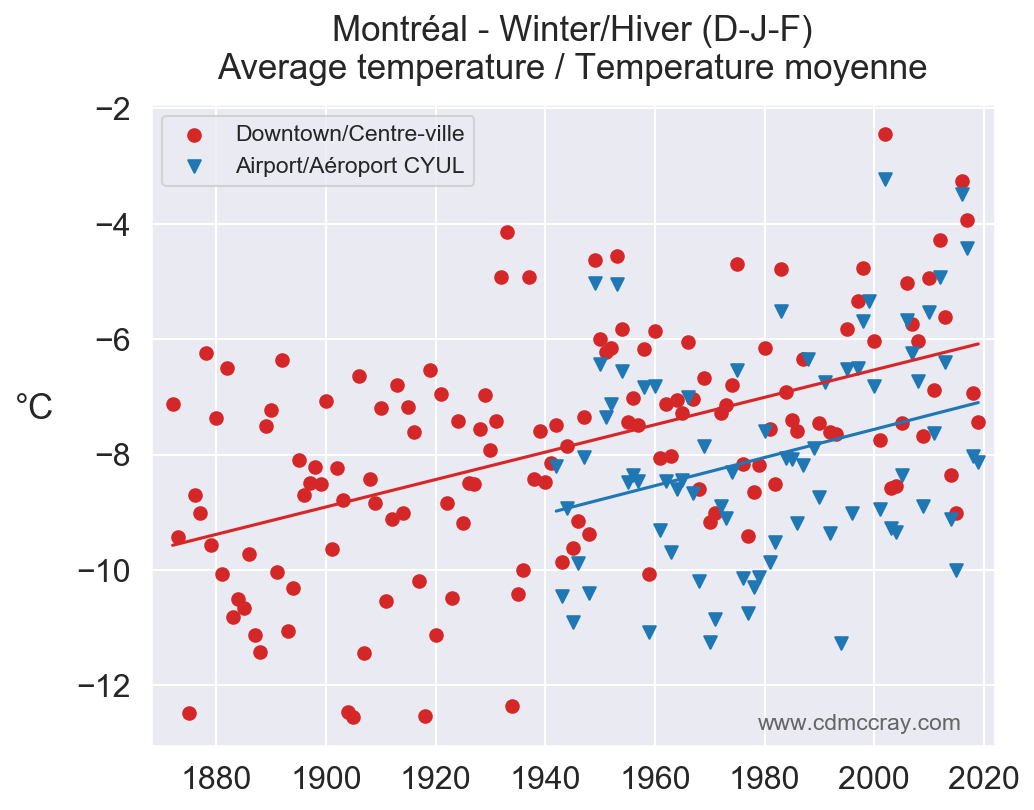

In [9]:
plot_both = True
var = 'Mean Temp (°C)'
yearly_data_mcg = mcgill_winter.groupby('season').mean().loc[good_winter_mcgill]
yearly_data_yul = yul_winter.groupby('season').mean().loc[good_winter_yul]

title = "Montréal - Winter/Hiver (D-J-F)\nAverage temperature / Temperature moyenne"
y_label = '°C' 
fig, ax = plot_trends(yearly_data_mcg, yearly_data_yul, var, title, y_label, plot_both=plot_both)


ax.text(0.72, 0.02, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11)

Text(0.72,0.02,'www.cdmccray.com')

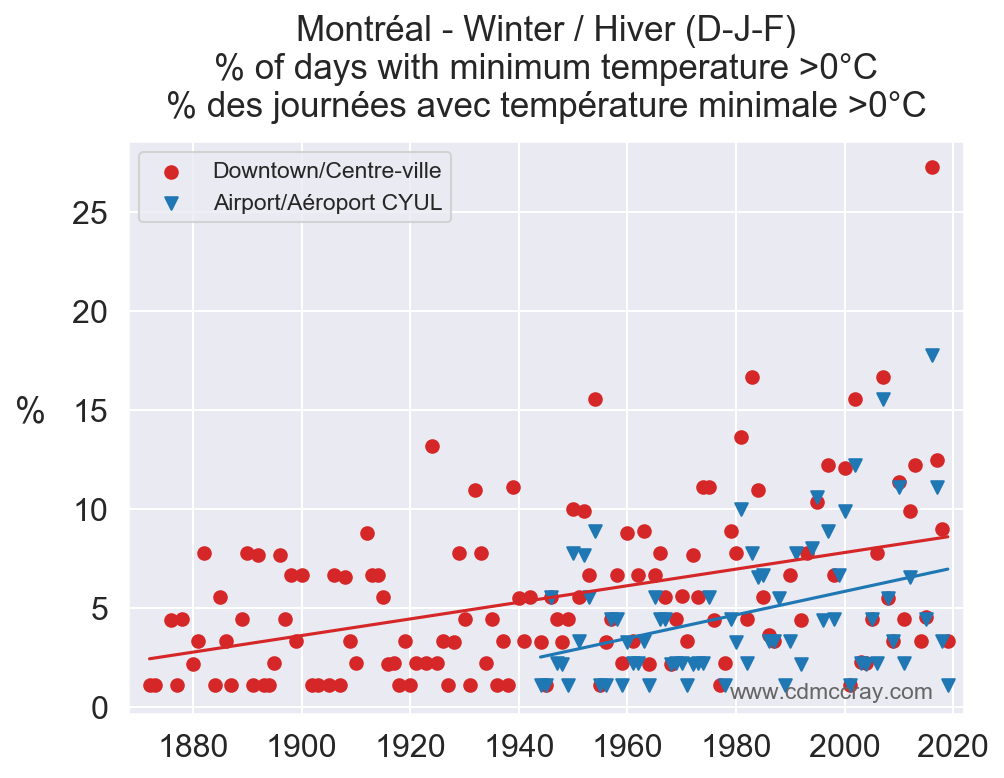

In [34]:
'''Percentage of days with min temp > 0C'''

plot_both = True
#Calculate number of days where min temp > 0 
yearly_data_mcg = mcgill_winter[(mcgill_winter['Min Temp (°C)'] >0)].groupby('season').count().loc[good_winter_mcgill]
yearly_data_yul = yul_winter[(yul_winter['Min Temp (°C)'] >0)].groupby('season').count().loc[good_winter_yul]
#Divide this by total number of winter days with observations
yearly_data_mcg['pct_min_ge0']  = yearly_data_mcg['Year']/obs_per_winter['mcgill_days']  *100
yearly_data_yul['pct_min_ge0']  = yearly_data_yul['Year']/obs_per_winter['yul_days'] *100
var = 'pct_min_ge0'

title = "Montréal - Winter / Hiver (D-J-F)\n% of days with minimum temperature >0°C\n% des journées avec température minimale >0°C"
y_label='%'
fig, ax = plot_trends(yearly_data_mcg, yearly_data_yul, var, title, y_label, plot_both=plot_both)

ax.text(0.72, 0.02, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11, zorder=1)

Text(0.72,0.02,'www.cdmccray.com')

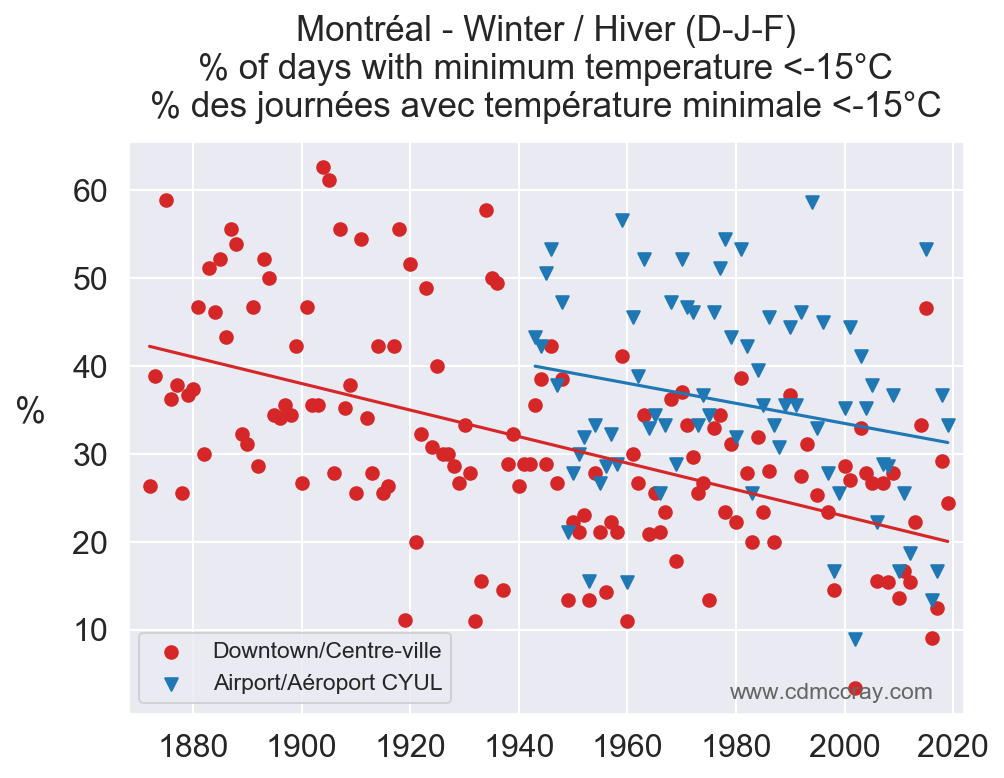

In [40]:
'''Same as above, but for % <-15C'''

plot_both = True
yearly_data_mcg = mcgill_winter[(mcgill_winter['Min Temp (°C)'] <-15)].groupby('season').count().loc[good_winter_mcgill]
yearly_data_yul = yul_winter[(yul_winter['Min Temp (°C)'] <-15)].groupby('season').count().loc[good_winter_yul]
yearly_data_mcg['pct_min_lt_-15']  = yearly_data_mcg['Year']/obs_per_winter['mcgill_days']  *100
yearly_data_yul['pct_min_lt_-15']  = yearly_data_yul['Year']/obs_per_winter['yul_days'] *100
var = 'pct_min_lt_-15'

title = "Montréal - Winter / Hiver (D-J-F)\n% of days with minimum temperature <-15°C\n% des journées avec température minimale <-15°C"
y_label='%'
fig, ax = plot_trends(yearly_data_mcg, yearly_data_yul, var, title, y_label, plot_both=plot_both)

ax.text(0.72, 0.02, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11, zorder=1)

# Precipitation

## Snowfall

Text(0.02,0.02,'www.cdmccray.com')

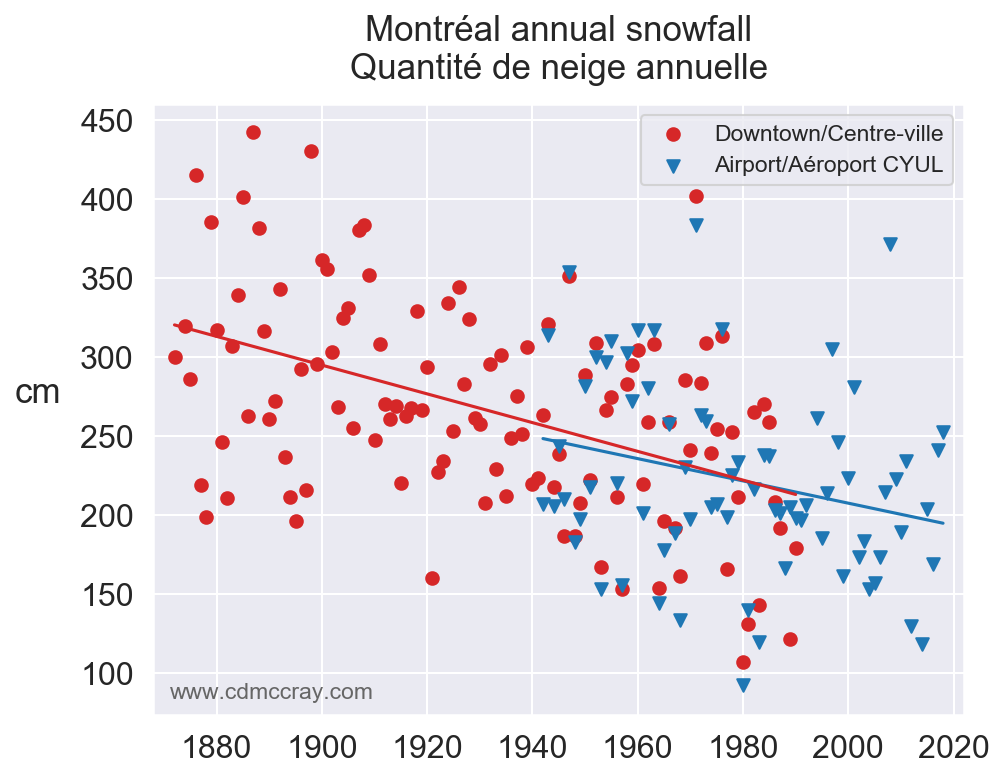

In [37]:
'''
Yearly total snowfall
'''

plot_both = True
var = 'Total Snow (cm)'
yearly_data_mcg = mcgill_all.groupby('season').sum().loc[good_years_mcgill]
yearly_data_yul = yul_all.groupby('season').sum().loc[good_years_yul]
title = "Montréal annual snowfall\nQuantité de neige annuelle"
y_label = 'cm'

fig, ax = plot_trends(yearly_data_mcg, yearly_data_yul, var, title, y_label, plot_both=plot_both)

ax.text(0.02, 0.02, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11, zorder=1)

Text(0.02,0.02,'www.cdmccray.com')

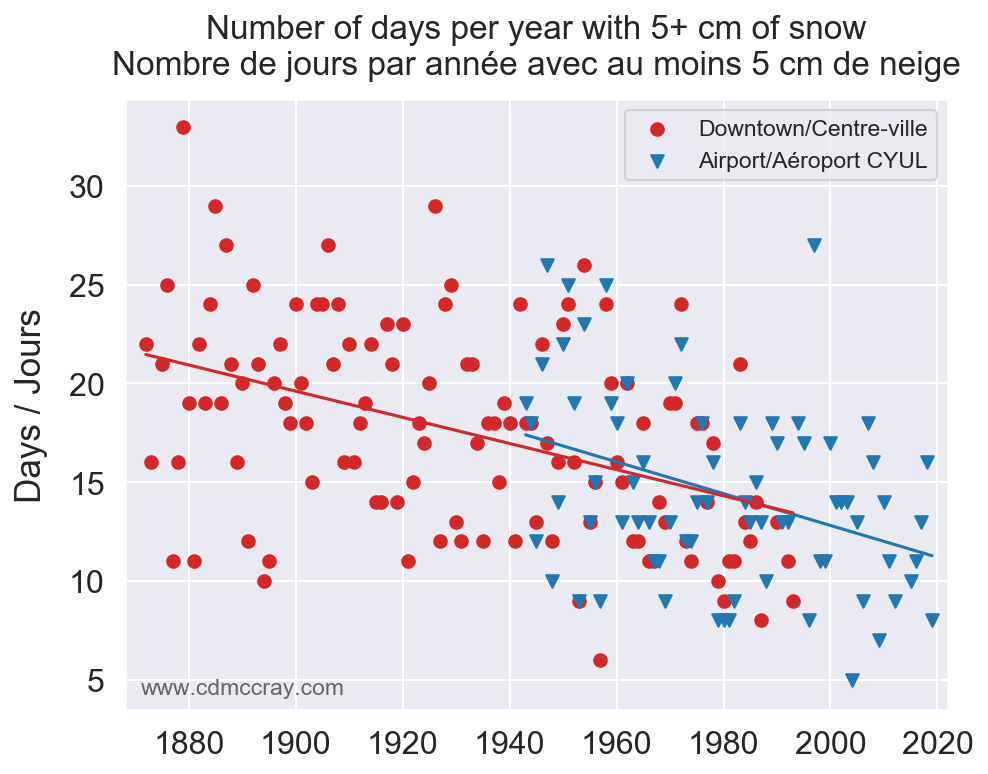

In [41]:
'''Count number of days with at least 5 cm of snowfall'''

plot_both = True
var = 'Total Snow (cm)'
yearly_data_mcg = mcgill_all[(mcgill_all['Total Snow (cm)']>=5) & (mcgill_all.Year.isin(good_winter_mcgill))].groupby('Year').count()
yearly_data_yul = yul_all[(yul_all['Total Snow (cm)']>=5) & (yul_all.Year.isin(good_winter_yul))].groupby('Year').count()
title = "Number of days per year with 5+ cm of snow\nNombre de jours par année avec au moins 5 cm de neige"

fig, ax = plot_trends(yearly_data_mcg, yearly_data_yul, var, title, y_label, plot_both=plot_both)

#Set ylabel separately because we want a different rotation than in the plot_trends function
ax.set_ylabel('Days / Jours', rotation=90, labelpad=10)
ax.set_title(title, fontsize=16)
ax.text(0.02, 0.02, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11, zorder=1)

## Rainfall

Text(0.72,0.02,'www.cdmccray.com')

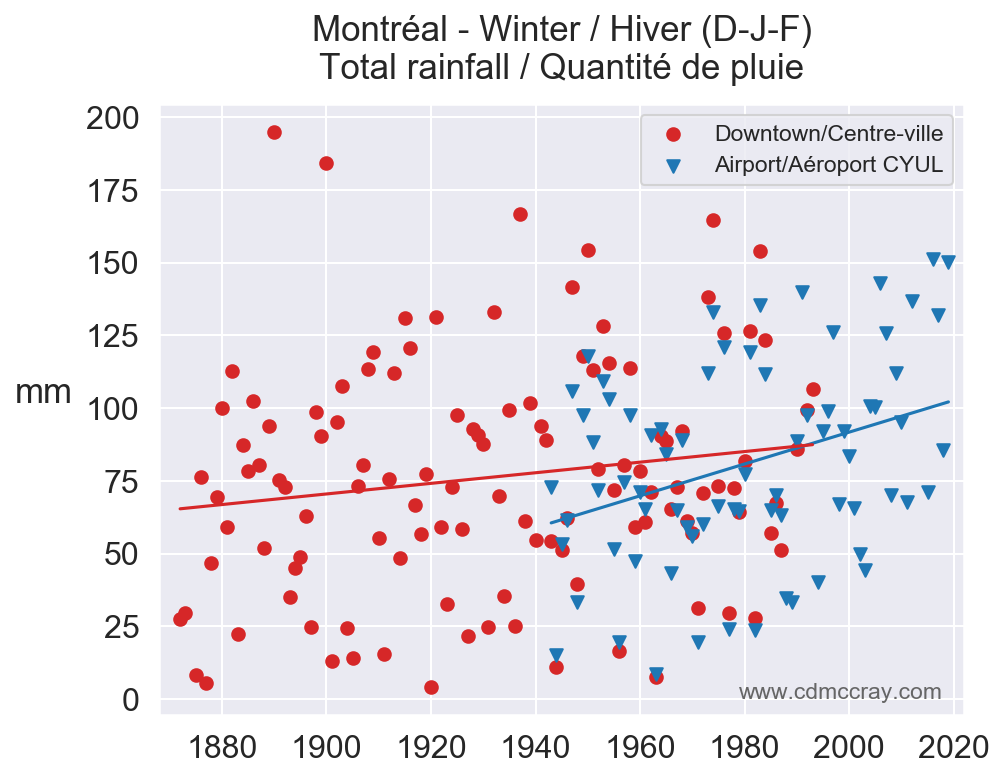

In [42]:
'''Total wintertime (DJF) rainfall'''

plot_both = True
var = 'Total Rain (mm)'
yearly_data_mcg = mcgill_winter.groupby('season').sum().loc[good_winter_mcgill]
yearly_data_yul = yul_winter.groupby('season').sum().loc[good_winter_yul]
y_label='mm'
title = "Montréal - Winter / Hiver (D-J-F)\nTotal rainfall / Quantité de pluie"

fig, ax = plot_trends(yearly_data_mcg, yearly_data_yul, var, title, y_label, plot_both=plot_both)

ax.text(0.72, 0.02, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11, zorder=1)

Text(0.75,0.01,'www.cdmccray.com')

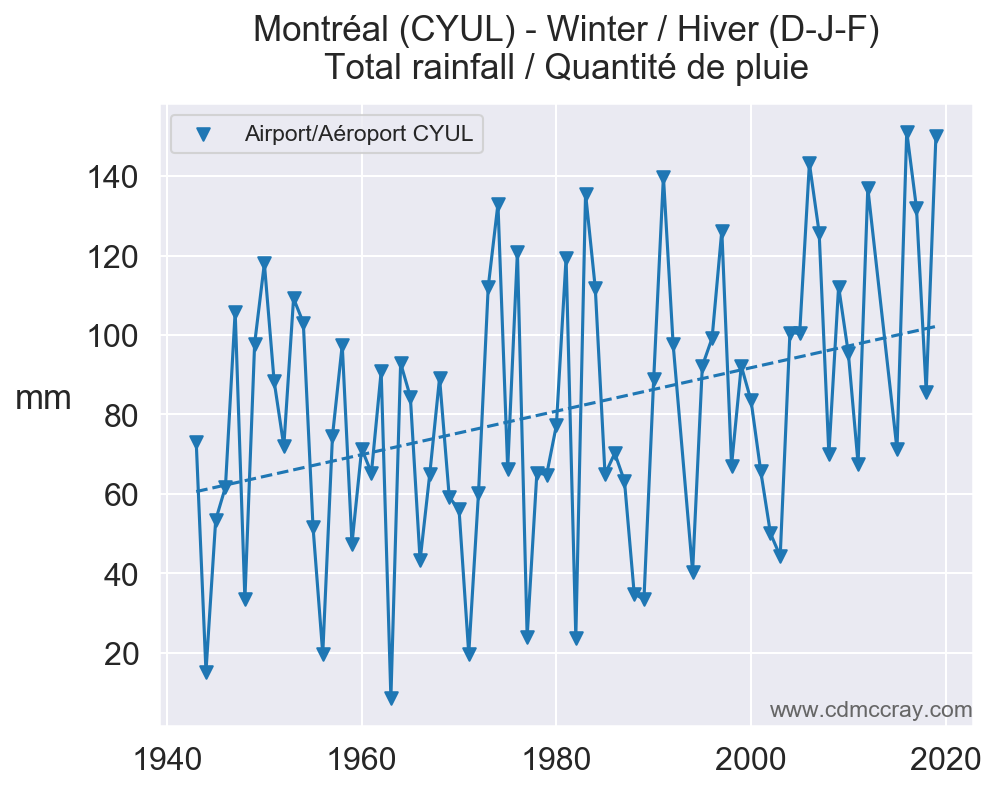

In [44]:
'''
Plot CYUL results separately in a different graph (don't use plot_trends function)
'''

var = 'Total Rain (mm)'
yearly_data_yul = yul_winter.groupby('season').sum().loc[good_winter_yul]

fig, ax = plt.subplots(figsize=[7,5.5], dpi=150)
title = "Montréal (CYUL) - Winter / Hiver (D-J-F)\nTotal rainfall / Quantité de pluie"
ax.set_title(title, y=1.02)


ax.scatter(x=yearly_data_yul.index,y=yearly_data_yul[var].values,  color=yul_color, marker=yul_marker,
          label=yul_label)
ax.plot(yearly_data_yul.index,yearly_data_yul[var].values,  color=yul_color)
dates = yearly_data_yul.index
#Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(yearly_data_yul.index,yearly_data_yul[var])
y = slope*dates + intercept

ax.plot(dates, y, color=yul_color, label=trend_label, ls='--')
ax.set_ylabel('mm', rotation=0, labelpad=20 )

ax.legend(fontsize=11)
ax.text(0.75, 0.01, 'www.cdmccray.com',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='0.4', fontsize=11)
